## 1) Нарисуйте (в каком-то виде) графики траекторий из data.csv.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file_path = 'data.csv'
data = pd.read_csv(file_path)

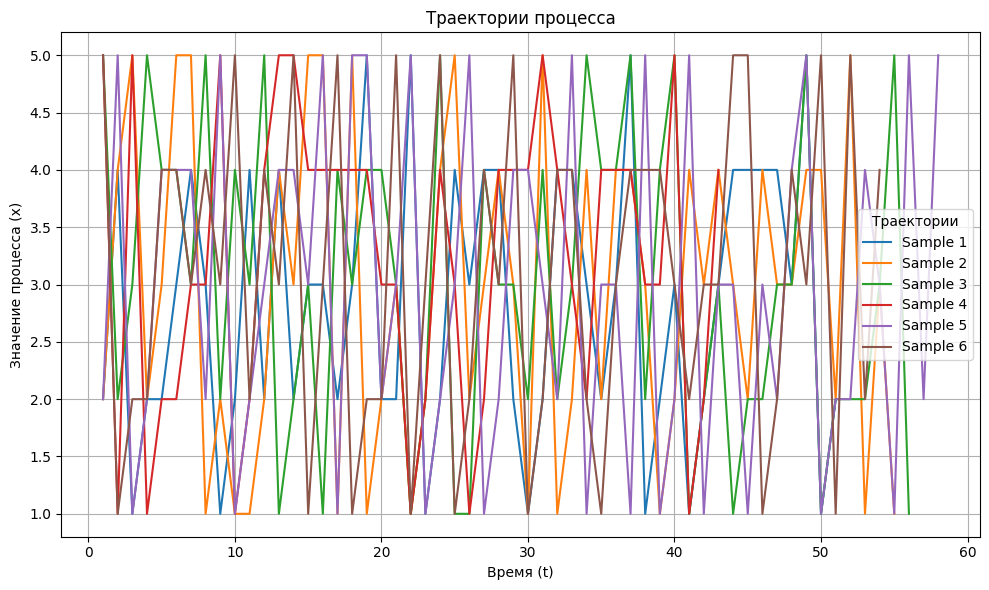

In [2]:
plt.figure(figsize=(10, 6))

for sample in data['sample'].unique():
    trajectory = data[data['sample'] == sample]
    plt.plot(trajectory['t'], trajectory['x'], label=f'Sample {sample}')

# Настройки графика
plt.title('Траектории процесса')
plt.xlabel('Время (t)')
plt.ylabel('Значение процесса (x)')
plt.legend(title='Траектории')
plt.grid(True)
plt.tight_layout()

# Показ графика
plt.show()

## 2) Получите в явном виде оценки максимального правдоподобия $\pi$ и P для нескольким независимым выборочным траекториям.

Вот такая формула для $\hat{\pi}_k$:
$$
\hat{\pi}_k = \frac{\#(x_{i1} = k)}{\sum_{k=1}^{p} \#(x_{i1} = k)}
$$
И вот такая для P:
$$
P_{lm} = \frac{\#(x_{it} = m, x_{it-1} = l)}{\sum_{m=1}^{p} \#(x_{it} = m, x_{it-1} = l)}
$$
Запрограмируем 

In [3]:
def estimate_initial_distribution(data,n):
    initial_dist = np.zeros(n)
    for i in data[data['t'] == 1]['x']:
        initial_dist[i-1] += 1
    pi = initial_dist / np.sum(initial_dist) 
    return pi


def estimate_transition_matrix(data,n):
    transition_matrix = np.zeros((n,n))
    for sample in data['sample'].unique():
        trajectory = data[data['sample'] == sample]
        for i in range(len(trajectory) - 1):
            current_state = trajectory.iloc[i]['x']
            next_state = trajectory.iloc[i + 1]['x']
            transition_matrix[current_state-1,next_state-1] += 1
    row_sums = transition_matrix.sum(axis=1, keepdims=True)
    normalized_matrix = np.divide(transition_matrix, row_sums, where=row_sums != 0)
    return normalized_matrix

## 3) Оцените $\pi$ и P по методу максимального правдоподобия исходя из данных в data.csv.

In [4]:
pi = estimate_initial_distribution(data,5)
pi

array([0. , 0.5, 0. , 0. , 0.5])

In [5]:
P = estimate_transition_matrix(data,5)
P

array([[0.03846154, 0.65384615, 0.13461538, 0.03846154, 0.13461538],
       [0.04225352, 0.12676056, 0.28169014, 0.42253521, 0.12676056],
       [0.21538462, 0.12307692, 0.15384615, 0.15384615, 0.35384615],
       [0.01428571, 0.11428571, 0.4       , 0.37142857, 0.1       ],
       [0.64150943, 0.18867925, 0.        , 0.0754717 , 0.09433962]])

## 4) Пусть $( X_1,..., X_n )$ — значения из первой выборочной траектории (где \( n \) — последний момент времени, для которого присутствует наблюдение в выборочной траектории). Исходя из полученных оценок для начального распределения и матрицы переходных вероятностей, вычислите условные вероятности: $P(\xi(n+1) = x \mid X_1,..., X_n)$ и $P(\xi(n+2) = x \mid X_1,..., X_n)$ для всех x $\in$ $\text{dom}\xi$.



In [6]:
def get_future_step(last_record,Pf,step):
    result = Pf[last_record-1]
    for _ in range(step-1):
        result = result @ Pf
    return result

## ЗАДАНИЕ 2

In [7]:

import random
def generate_markov_trajectory(pi,P,sample,max_t):
    t1 = np.random.choice(len(pi), p=pi)
    trajectory = [[sample, 1, t1 + 1]]
    
    for t in range(1, max_t):
        current_state = trajectory[-1][2] - 1 
        next_state = np.random.choice(len(P), p=P[current_state])
        trajectory.append([sample, t+1, next_state + 1]) 
    
    return trajectory

In [8]:
a = generate_markov_trajectory(pi,P,1,5)
a

[[1, 1, 5], [1, 2, 1], [1, 3, 1], [1, 4, 3], [1, 5, 3]]

In [9]:
from tqdm import tqdm
pi_results = []
P_results = []
last_records = []

pt1_result = []
pt2_result = []

max_t_per_sample = data.groupby('sample')['t'].max()
for k in tqdm(range(1000), desc="Итерации"):
    trajectories = []
    for sample in range(1,7):
        max_t = max_t_per_sample.get(sample, random.randint(45, 60))
        traj = generate_markov_trajectory(pi,P,sample,max_t)
        trajectories.extend(traj)
        
    new_data = pd.DataFrame(trajectories, columns=["sample", "t", "x"])
    
    pi_new = estimate_initial_distribution(new_data,5)
    P_new = estimate_transition_matrix(new_data,5)
    
    pi_results.append(pi_new)
    P_results.append(P_new)
    
    


Итерации: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.78it/s]


# Дисперсии для $\pi$ и $P$

In [10]:
def get_variance(pi_results,P_results):
    # Оценка дисперсии для pi
    pi_var = np.var(pi_results, axis=0)  # Дисперсия для каждого элемента pi
    # Оценка дисперсии для P
    P_var = np.var(P_results, axis=0)  # Дисперсия для каждого элемента P
    
    df_pi = pd.DataFrame({
        'Дисперсия': pi_var})
    df_P_var = pd.DataFrame(P_var, columns=[i + 1 for i in range(P_var.shape[1])], 
                            index=[i + 1 for i in range(P_var.shape[0])])
    print("\nДисперсия для pi")
    display(df_pi)
    print("\nДисперсия для P:")
    display(df_P_var)


In [11]:
get_variance(pi_results,P_results)


Дисперсия для pi


,Дисперсия
0,0.000000
1,0.043002
2,0.000000
3,0.000000
4,0.043002



Дисперсия для P:


,1,2,3,4,5
1,0.000681,0.004322,0.002231,0.000768,0.002311
2,0.000607,0.001529,0.002658,0.003255,0.001566
3,0.002814,0.001828,0.001891,0.001892,0.003519
4,0.000215,0.001601,0.003511,0.003377,0.001305
5,0.004121,0.002728,0.000000,0.001242,0.001560


## 0.9 Квантиль Для $P(\xi(n+1))$ и 0.9 Квантиль Для $P(\xi(n+2))$

In [12]:
def get_quantile(P_results):
    first_sample_records = data[data['sample'] == 1]["x"].tolist()

    pt1_result = np.array([get_future_step(record, P_new, 1) for record, P_new in zip(first_sample_records, P_results)])
    pt1_lower = np.quantile(pt1_result, 0.05, axis=0)
    pt1_upper = np.quantile(pt1_result, 0.95, axis=0)
    
    print("Для P(xi(n+1))")
    print(pt1_lower)
    print(pt1_upper)

    pt2_result = np.array([get_future_step(record, P_new, 2) for record, P_new in zip(first_sample_records, P_results)])
    pt2_lower = np.quantile(pt2_result, 0.05, axis=0)
    pt2_upper = np.quantile(pt2_result, 0.95, axis=0)

    print("Для P(xi(n+2))")
    print(pt2_lower)
    print(pt2_upper)

In [13]:
get_quantile(P_results)

Для P(xi(n+1))
[0.         0.06599261 0.         0.01745598 0.05852273]
[0.59801678 0.68787879 0.4122807  0.47264919 0.42960634]
Для P(xi(n+2))
[0.0834031  0.11378966 0.13086825 0.14843744 0.11581513]
[0.31610292 0.4464344  0.26810659 0.34482685 0.22395392]


## Гистограммы для p{0,0} p{2,2} p{4,4} и pi{1}, pi{4}, pi{0}

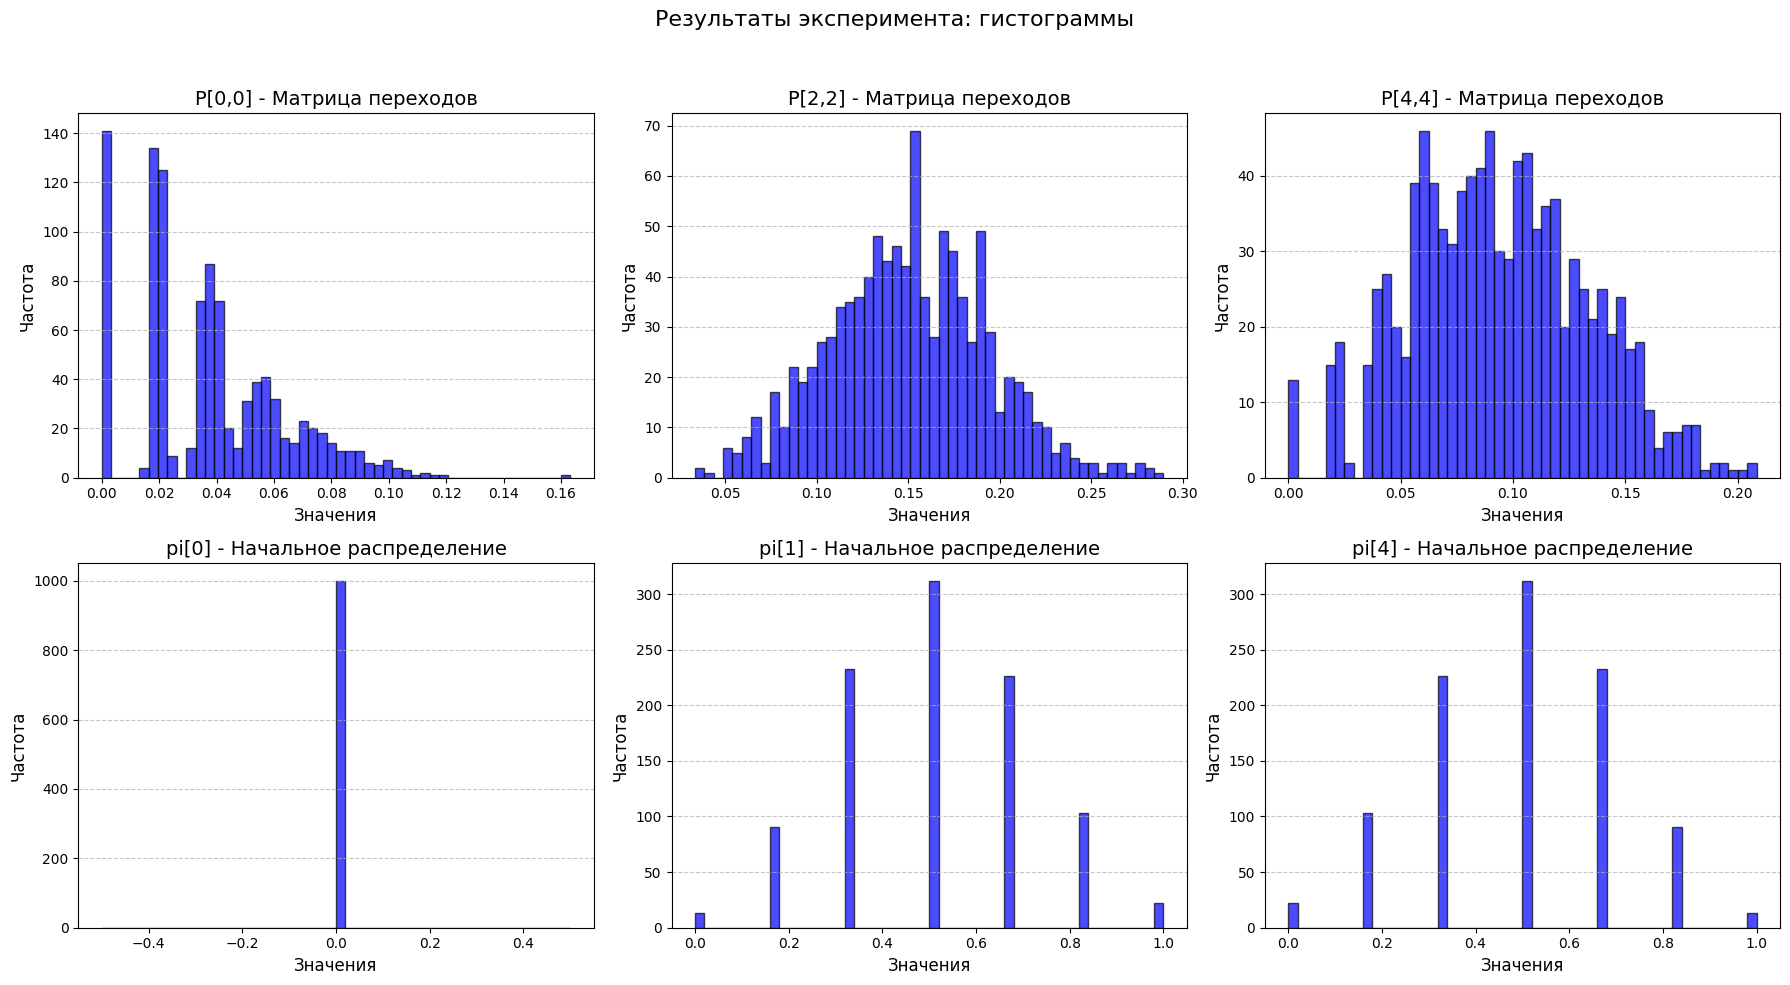

In [14]:
def plot_experiment_histograms(pi_results, P_results, bins=50):
    # Выбираем нужные элементы для визуализации
    p00 = P_results[:, 0, 0]  # Все P[0,0] из каждой итерации
    p22 = P_results[:, 2, 2]  # Все P[2,2]
    p44 = P_results[:, 4, 4]  # Все P[4,4]
    
    pi0 = pi_results[:, 0]  # Все pi[0]
    pi1 = pi_results[:, 1]  # Все pi[1]
    pi4 = pi_results[:, 4]  # Все pi[4]

    # Названия для графиков
    titles = [
        "P[0,0] - Матрица переходов",
        "P[2,2] - Матрица переходов",
        "P[4,4] - Матрица переходов",
        "pi[0] - Начальное распределение",
        "pi[1] - Начальное распределение",
        "pi[4] - Начальное распределение"
    ]
    
    data_list = [p00, p22, p44, pi0, pi1, pi4]
    
    # Настраиваем сетку графиков
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()  # Для удобной индексации

    for i, (data, title) in enumerate(zip(data_list, titles)):
        axes[i].hist(data, bins=bins, color="blue", edgecolor="black", alpha=0.7)
        axes[i].set_title(title, fontsize=14)
        axes[i].set_xlabel("Значения", fontsize=12)
        axes[i].set_ylabel("Частота", fontsize=12)
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)

    plt.suptitle("Результаты эксперимента: гистограммы", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_experiment_histograms(np.array(pi_results), np.array(P_results),bins = 50)

## Делаем такую же движуху способом из 6.2


In [15]:
tetta_P = np.clip(2 * P - P_results, 0, 1)
tetta_pi = np.clip(2 * pi - pi_results, 0, 1)

In [16]:
get_variance(tetta_pi,tetta_P)


Дисперсия для pi


,Дисперсия
0,0.000000
1,0.043002
2,0.000000
3,0.000000
4,0.043002



Дисперсия для P:


,1,2,3,4,5
1,0.000558,0.004322,0.002217,0.000583,0.002267
2,0.000509,0.001529,0.002658,0.003255,0.001564
3,0.002814,0.001797,0.001891,0.001886,0.003519
4,0.000123,0.001570,0.003511,0.003377,0.001277
5,0.004121,0.002728,0.000000,0.001157,0.001545


In [17]:
get_quantile(tetta_P)

Для P(xi(n+1))
[0.         0.04937961 0.         0.04071749 0.05222219]
[0.58604917 0.6502849  0.44961637 0.47544526 0.395116  ]
Для P(xi(n+2))
[0.0995151  0.10243379 0.14454104 0.1314671  0.11618738]
[0.26051469 0.41066665 0.29457065 0.34025251 0.23703033]


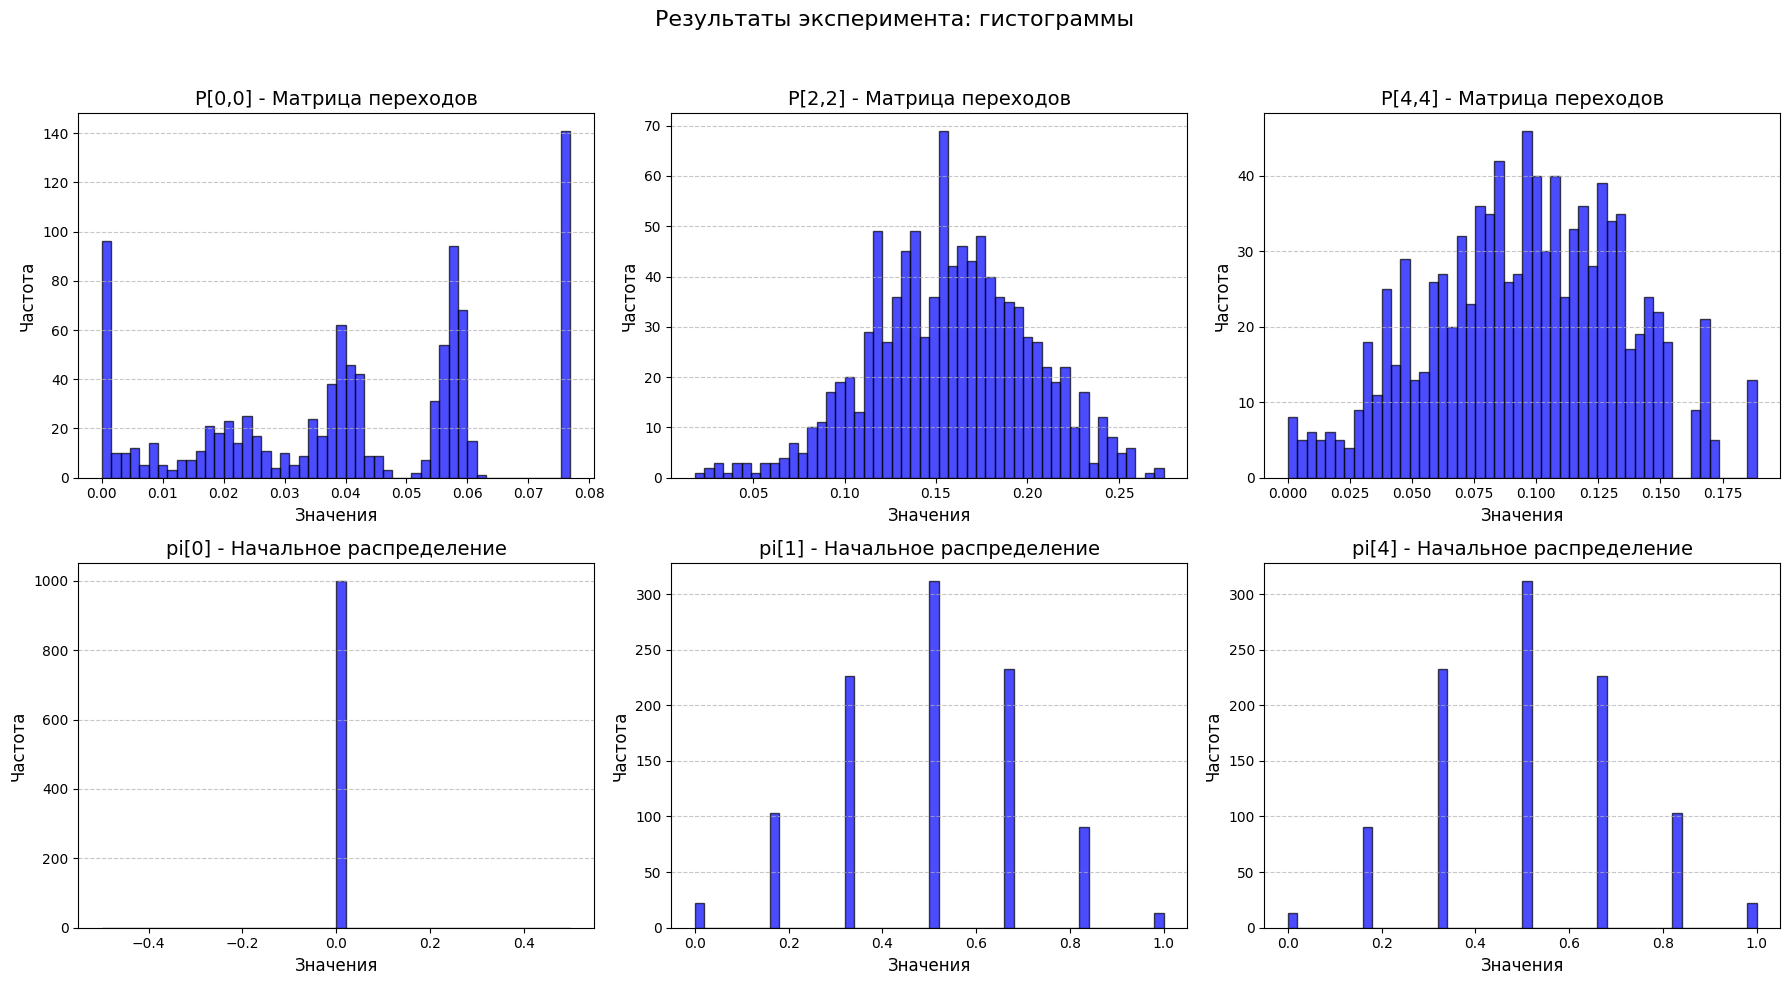

In [18]:
plot_experiment_histograms(np.array(tetta_pi), np.array(tetta_P),bins = 50)

# Задание№3

## Сформируйте выборку предполагаемых значений $\theta^{*}_{1}...\theta^{*}_{n}$ параметра $\theta = (\pi,P)$ c k = 10000 исходя из метода, описанного в п. 7, используя метод Метрополиса-Гастингса.

In [19]:
from itertools import product
K = 10000
Pi_degree = np.array([sum(data[data["t"]==1]["x"] == k+1)  for k in range(len(pi))])
P_degree = np.zeros((len(pi), len(pi)))
for l, m in product(range(1, len(pi)+1),  range(1, len(pi)+1)):
    for i in range(data.shape[0] - 1):
        if data.iloc[i]["x"] == l and data.iloc[i+1]["x"] == m and data.iloc[i]["sample"] == data.iloc[i+1]["sample"]:
            P_degree[l-1, m-1] += 1


In [20]:
import numpy as np

def likelihood_prod(Pi, P,Pi_degree,P_degree):
    _Pi = Pi.copy()
    _P = P.copy()
    pi_product = np.prod(_Pi ** Pi_degree)
    p_product = np.prod(_P ** P_degree, axis=1)
    return np.prod(pi_product) * np.prod(p_product)

def metropolis_hastings_markov_chain(pi,P, k, sigma2):
    xi_pi = [pi]
    xi_P = [P]
    curr_xi_pi = xi_pi[0]
    curr_xi_P = xi_P[0]
    accepted_count = 0

    for i in range(1, k):
        # Предложение новых параметров
        eta = np.random.uniform(0, 1)
        pi_gamma = np.random.normal(loc=0, scale = sigma2, size = pi.shape)
        P_gamma = np.random.normal(loc=0, scale = sigma2, size = P.shape)

        pi_theta = pi_gamma + curr_xi_pi
        pi_theta[:-1] = np.clip(pi_theta[:-1], 0, 1)
        pi_theta[-1] = 1 - np.sum(pi_theta[:-1])
        # print(pi_theta.sum()==1)

        P_theta = P_gamma + curr_xi_P
        P_theta[:, :-1] = np.clip(P_theta[:, :-1], 0, 1)
        P_theta[:, -1] = 1 - np.sum(P_theta[:, :-1], axis=1)
        # print(P_theta.sum()==5)
        
        acceptance_ratio = likelihood_prod(pi_theta,P_theta,Pi_degree,P_degree) / likelihood_prod(curr_xi_pi,curr_xi_P,Pi_degree,P_degree)
        
        if eta <= acceptance_ratio:
            accepted_count+=1
            xi_pi.append(pi_theta)
            xi_P.append(P_theta)
            
            curr_xi_pi = pi_theta
            curr_xi_P = P_theta
        else:
            xi_pi.append(curr_xi_pi)
            xi_P.append(curr_xi_P)
    print((accepted_count/k))
    return xi_pi, xi_P

In [21]:
# Запуск алгоритма
pi_results, P_results = metropolis_hastings_markov_chain(pi, P, 10000, 0.001)

0.931


# Дисперсии для $\pi$ и $P$

In [22]:
get_variance(pi_results,P_results)


Дисперсия для pi


,Дисперсия
0,0.001308
1,0.000791
2,0.000520
3,0.000169
4,0.000972



Дисперсия для P:


,1,2,3,4,5
1,0.000956,0.000714,0.000492,0.000412,0.000777
2,0.000147,0.000180,0.000989,0.000565,0.000790
3,0.000514,0.000593,0.000638,0.000337,0.003035
4,0.001069,0.000318,0.001143,0.000347,0.001707
5,0.001133,0.001388,0.000071,0.000431,0.000610


## 0.9 Квантиль Для $P(\xi(n+1))$ и 0.9 Квантиль Для $P(\xi(n+2))$

In [23]:
get_quantile(P_results)

Для P(xi(n+1))
[0.01673612 0.10389144 0.01042857 0.05177744 0.08919216]
[0.64221113 0.64966735 0.3966029  0.43115299 0.34811808]
Для P(xi(n+2))
[0.09241211 0.13652969 0.15032802 0.15916233 0.1220811 ]
[0.2721269  0.4647182  0.25382095 0.33214529 0.20376298]


## Гистограммы для p{0,0} p{2,2} p{4,4} и pi{1}, pi{4}, pi{0}

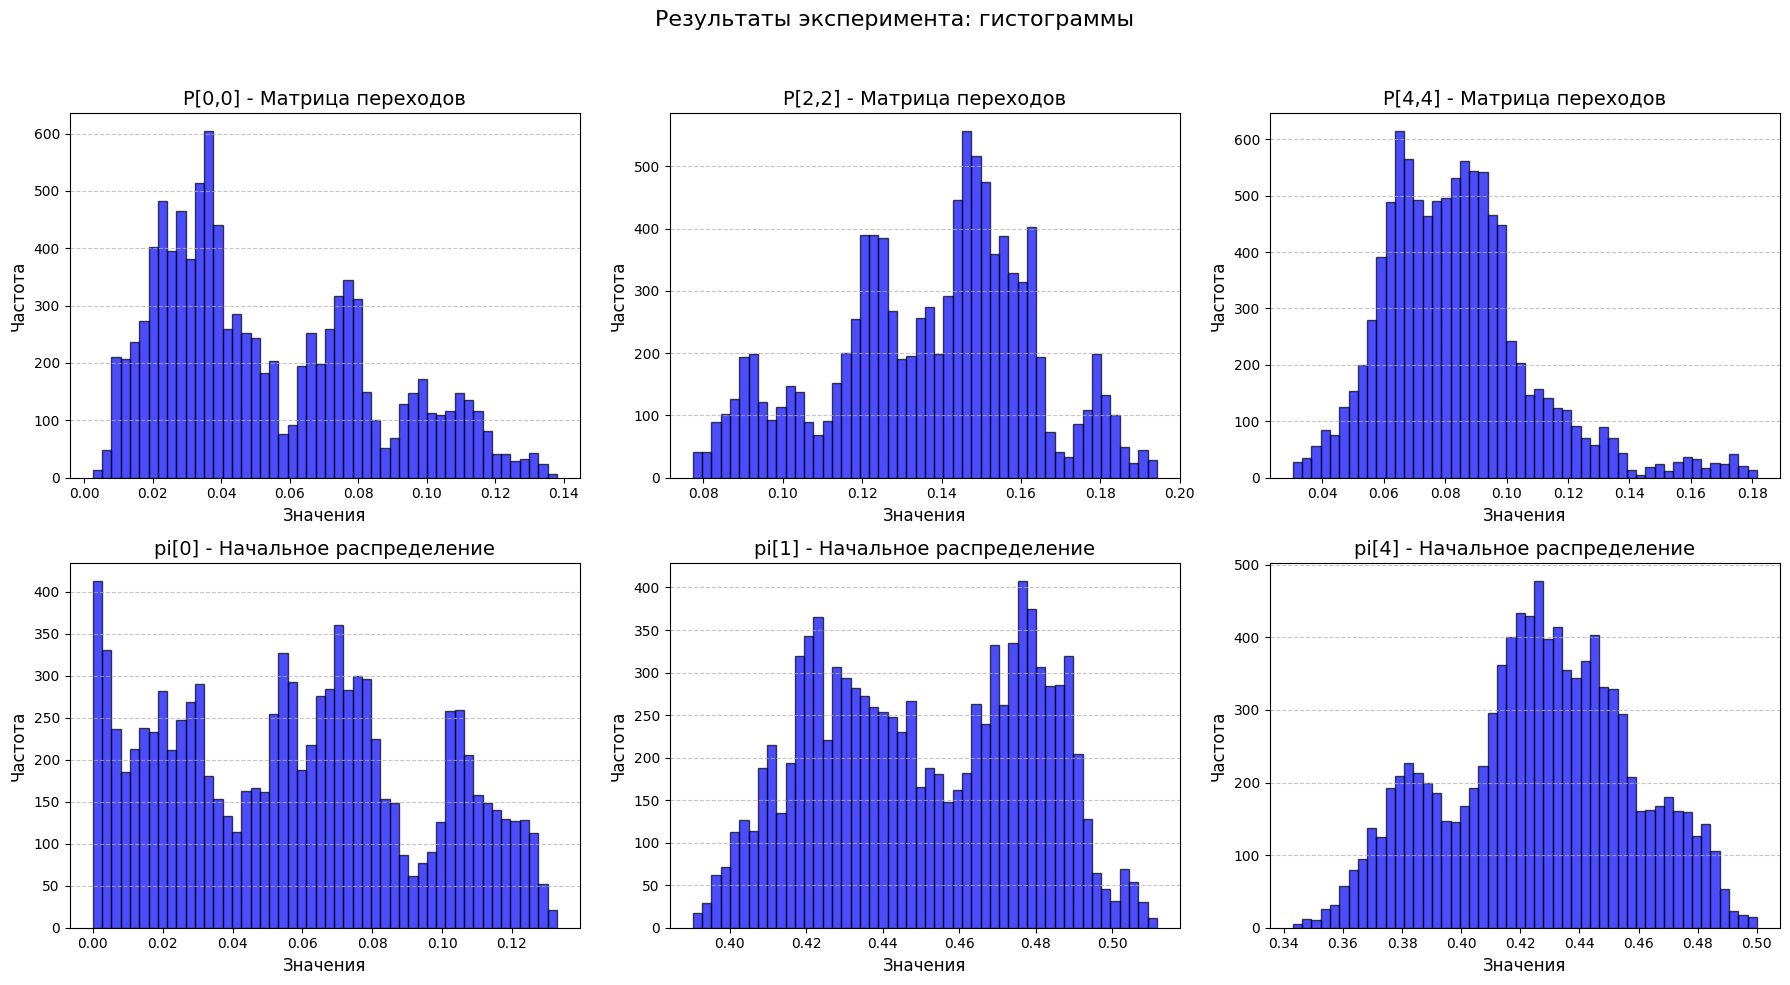

In [24]:
plot_experiment_histograms(np.array(pi_results), np.array(P_results),bins = 50)

## Сравним результаты из пункта 2 и 3: Ну, разные, да. Метод Метрополиса-Гастингса рулит